In [1]:
!pip install gTTS pyttsx3
!pip install opencv-python

import cv2
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
from gtts import gTTS
from IPython.display import Audio, display
import pyttsx3
import time

In [2]:
from huggingface_hub import login

login(token="your api key")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
!pip install timm
!pip install gTTS pyttsx3
import cv2
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
from gtts import gTTS
from IPython.display import Audio, display
import time

In [4]:
from transformers import DetrForObjectDetection, DetrImageProcessor

# Load DETR model and processor from Hugging Face
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

# Function to convert text to speech using gTTS and play it
def generate_audio(description):
    tts = gTTS(text=description, lang='en')
    tts.save("output.mp3")
    display(Audio("output.mp3", autoplay=True))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

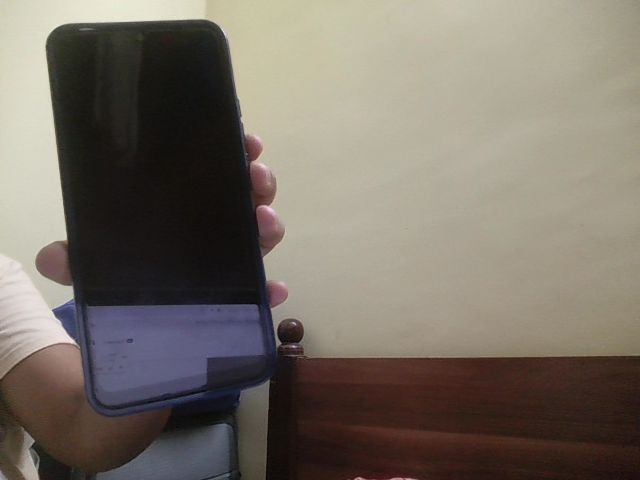

In [7]:
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab

def capture_image():
    js = Javascript('''
        async function captureImage() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const button = document.createElement('button');
            button.textContent = 'Capture Image';
            document.body.appendChild(div);
            div.appendChild(video);
            div.appendChild(button);
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();
            // Capture the image when the button is clicked
            await new Promise((resolve) => button.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            const dataUrl = canvas.toDataURL('image/jpeg', 0.8);
            div.remove();
            return dataUrl;
        }
        captureImage();
    ''')
    display(js)
    data = eval_js('captureImage()')
    binary = b64decode(data.split(',')[1])
    with open('photo.jpg', 'wb') as f:
        f.write(binary)

    img = cv2.imread('photo.jpg')
    return img

# Capture the image and display it
img = capture_image()
cv2_imshow(img)  # Correctly using cv2_imshow to display the image in Colab


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


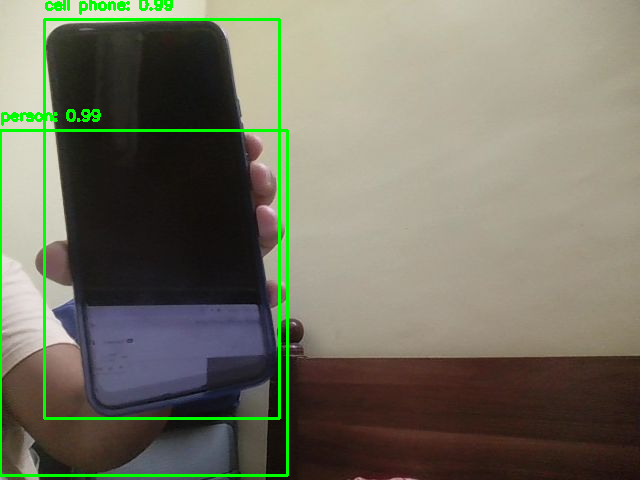

In [9]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

# Load the model and processor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50').to(device)
processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

def detect_objects(image, device, processor, model):
    # Convert image to correct format
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Forward pass through the model
    outputs = model(**inputs)

    # Post-process the outputs to detect objects
    target_sizes = torch.tensor([image.shape[:2]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    # Draw bounding boxes on the image
    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        box = [int(i) for i in box.tolist()]
        if score > 0.7:  # Set a confidence threshold
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            text = f"{model.config.id2label[label.item()]}: {score:.2f}"
            cv2.putText(image, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

# Now process the captured image with object detection
processed_frame = detect_objects(img, device, processor, model)
cv2_imshow(processed_frame)
